In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection_lgbm = json.load(f)

with open('../feat_selection/select_optuna_catb.json', 'r') as f:
    feature_selection_catb = json.load(f)

# Extract the selected features
numerical_cols = feature_selection_lgbm.get('numerical', [])
categorical_cols = feature_selection_lgbm.get('categorical', [])

# numerical_cols = list(set(feature_selection_lgbm.get('numerical', []) + feature_selection_catb.get('numerical', [])))
# categorical_cols = list(set(feature_selection_lgbm.get('categorical', []) + feature_selection_catb.get('categorical', [])))

text_cols = ["LudRules",]
# text_cols = list()

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))
print("Text features:", len(text_cols))

Numerical features: 296
Categorical features: 5
Text features: 1


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=True,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 370
Categorical Columns: 5


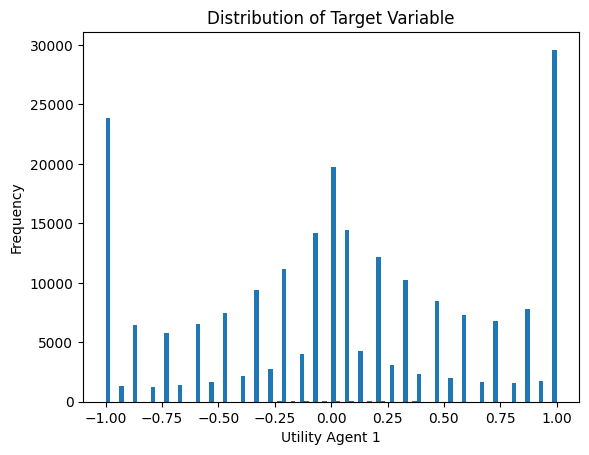

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [6]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [7]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [8]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):

    # Define the parameters for CatBoost
    params = {
        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }

        # # Text processing parameters to mimic TF-IDF
        'tokenizers': [{
            'tokenizer_id': 'Space',
            'separator_type': 'ByDelimiter',
            'delimiter': ' '
        }],
        'dictionaries': [{
            'dictionary_id': 'NgramDict',
            'max_dictionary_size': '500',  # Match max_features=500
            'occurrence_lower_bound': '3',
            'gram_order': '3',  # Maximum n-gram size
            'min_gram_order': '2'  # Minimum n-gram size
        }],
        'feature_calcers': [{
            'calcer_type': 'BoW',  # Most similar to TF-IDF
            'dictionary_id': 'NgramDict'
        }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Add TF-IDF features for text columns
        new_numerical_cols = list()
        for col in text_cols:
            tfidf = TfidfVectorizer(max_features=500, ngram_range=(2,3))
            tfidf_feats = tfidf.fit_transform(X_train[col]).toarray()
            
            # Create new column names
            new_cols = [f"{col}_tfidf_{i}" for i in range(tfidf_feats.shape[1])]
            new_numerical_cols.extend(new_cols)
            
            # Add TF-IDF features to training data
            X_train = pd.concat([
                X_train, 
                pd.DataFrame(tfidf_feats, columns=new_cols, index=X_train.index)
                ], 
                axis=1
            )
            
            # Transform validation data using fitted TF-IDF
            val_tfidf = tfidf.transform(X_valid[col]).toarray()
            X_valid = pd.concat([
                X_valid,
                pd.DataFrame(val_tfidf, columns=new_cols, index=X_valid.index)
                ],
                axis=1
            )
        
        # Add new column names to numerical features
        _numerical_cols = numerical_cols + new_numerical_cols
        
        print("len(numerical_cols):", len(_numerical_cols))
        print("len(categorical_cols):", len(categorical_cols))

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            data=X_train[_numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            data=X_valid[_numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        plot_feature_importance(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores


Fold 1
len(numerical_cols): 870
len(categorical_cols): 5
0:	learn: 0.6118720	test: 0.5516010	best: 0.5516010 (0)	total: 235ms	remaining: 11m 44s
50:	learn: 0.3901279	test: 0.4658276	best: 0.4658276 (50)	total: 8.14s	remaining: 7m 50s
100:	learn: 0.3575246	test: 0.4488396	best: 0.4488396 (100)	total: 16.8s	remaining: 8m 2s
150:	learn: 0.3372374	test: 0.4408788	best: 0.4408788 (150)	total: 25.3s	remaining: 7m 58s
200:	learn: 0.3235621	test: 0.4360926	best: 0.4360926 (200)	total: 33.8s	remaining: 7m 51s
250:	learn: 0.3124478	test: 0.4335851	best: 0.4335851 (250)	total: 42.5s	remaining: 7m 45s
300:	learn: 0.3038161	test: 0.4315824	best: 0.4315824 (300)	total: 51.2s	remaining: 7m 38s
350:	learn: 0.2955253	test: 0.4295853	best: 0.4295822 (348)	total: 59.6s	remaining: 7m 30s
400:	learn: 0.2893931	test: 0.4291261	best: 0.4290445 (397)	total: 1m 8s	remaining: 7m 24s
450:	learn: 0.2839437	test: 0.4282311	best: 0.4282260 (449)	total: 1m 17s	remaining: 7m 19s
500:	learn: 0.2788232	test: 0.4274994	

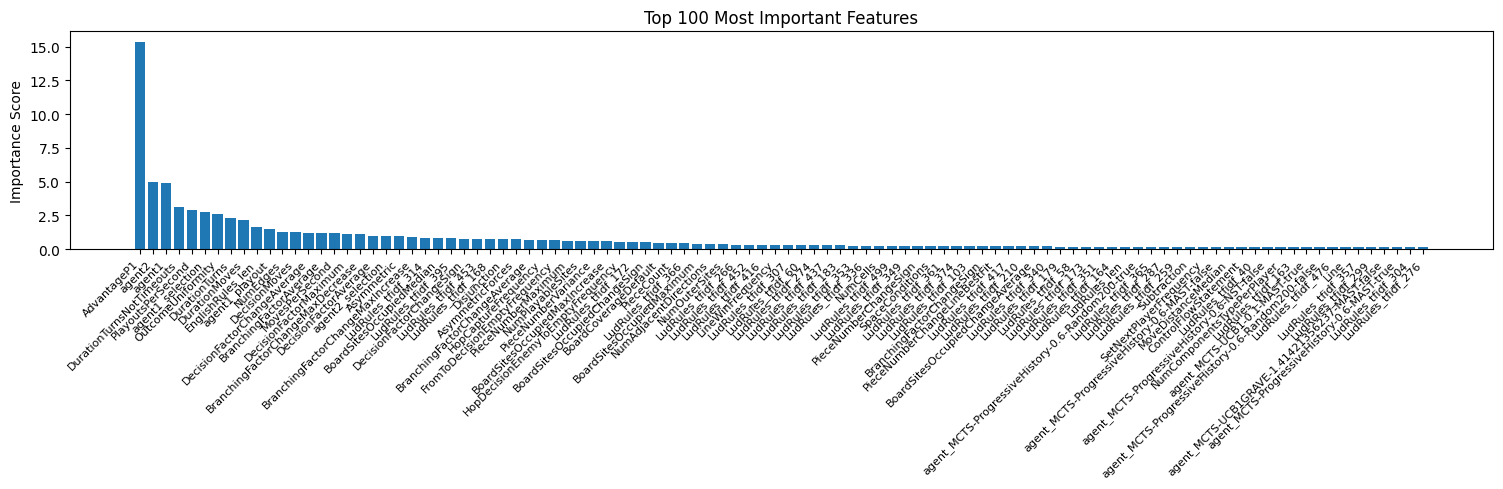

Fold 1 - RMSE: 0.42198822339850556
Fold 2
len(numerical_cols): 870
len(categorical_cols): 5
0:	learn: 0.6063562	test: 0.5827068	best: 0.5827068 (0)	total: 194ms	remaining: 9m 40s
50:	learn: 0.3968489	test: 0.4846033	best: 0.4837222 (46)	total: 10.1s	remaining: 9m 42s
100:	learn: 0.3656791	test: 0.4739606	best: 0.4738791 (99)	total: 20.8s	remaining: 9m 55s
150:	learn: 0.3449640	test: 0.4663745	best: 0.4663745 (150)	total: 30.6s	remaining: 9m 37s
200:	learn: 0.3301345	test: 0.4627340	best: 0.4627340 (200)	total: 40.6s	remaining: 9m 25s
250:	learn: 0.3192242	test: 0.4604393	best: 0.4604215 (248)	total: 50.6s	remaining: 9m 13s
300:	learn: 0.3099904	test: 0.4582920	best: 0.4582920 (300)	total: 1m 1s	remaining: 9m 7s
350:	learn: 0.3021443	test: 0.4577700	best: 0.4576498 (347)	total: 1m 10s	remaining: 8m 54s
400:	learn: 0.2955744	test: 0.4561851	best: 0.4561646 (399)	total: 1m 20s	remaining: 8m 41s
450:	learn: 0.2899524	test: 0.4554933	best: 0.4553778 (442)	total: 1m 30s	remaining: 8m 29s
500

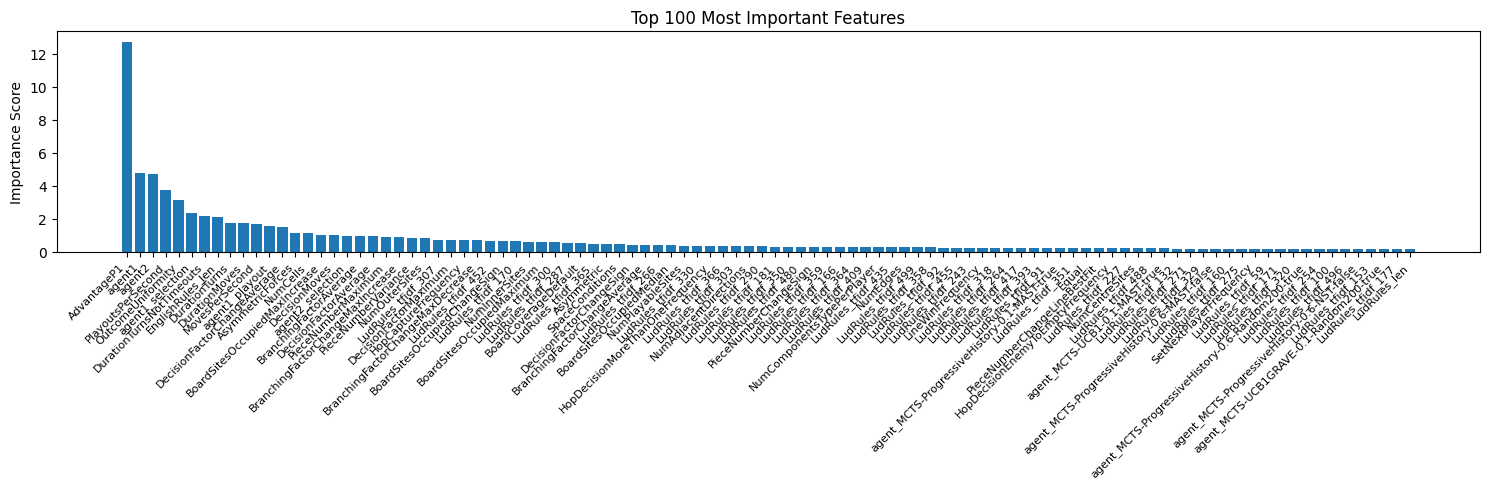

Fold 2 - RMSE: 0.447839035797936
Fold 3
len(numerical_cols): 870
len(categorical_cols): 5
0:	learn: 0.6015031	test: 0.5971688	best: 0.5971688 (0)	total: 176ms	remaining: 8m 48s
50:	learn: 0.3964026	test: 0.4801333	best: 0.4800074 (49)	total: 9.51s	remaining: 9m 9s
100:	learn: 0.3632421	test: 0.4665269	best: 0.4665269 (100)	total: 19.4s	remaining: 9m 16s
150:	learn: 0.3444874	test: 0.4584712	best: 0.4584712 (150)	total: 29.2s	remaining: 9m 10s
200:	learn: 0.3306961	test: 0.4536888	best: 0.4536819 (197)	total: 38.8s	remaining: 9m
250:	learn: 0.3199862	test: 0.4509154	best: 0.4509154 (250)	total: 48.3s	remaining: 8m 49s
300:	learn: 0.3104237	test: 0.4486965	best: 0.4486965 (300)	total: 57.7s	remaining: 8m 37s
350:	learn: 0.3020842	test: 0.4472455	best: 0.4472455 (350)	total: 1m 7s	remaining: 8m 25s
400:	learn: 0.2958436	test: 0.4459878	best: 0.4459878 (400)	total: 1m 16s	remaining: 8m 15s
450:	learn: 0.2894434	test: 0.4449982	best: 0.4449982 (450)	total: 1m 25s	remaining: 8m 5s
500:	learn

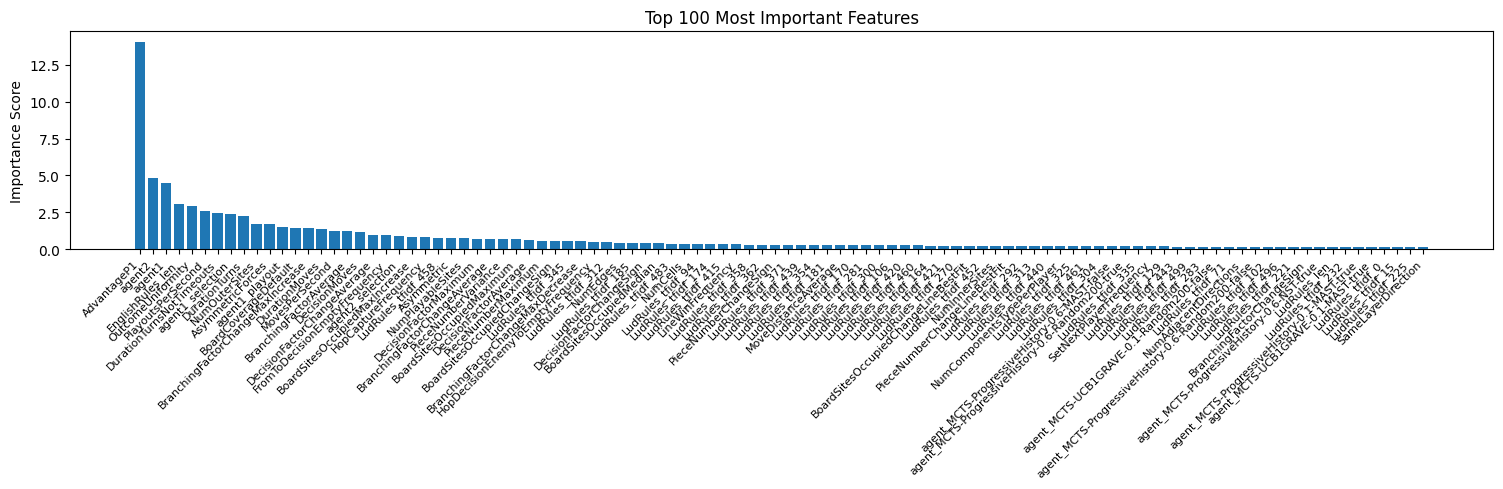

Fold 3 - RMSE: 0.4386859771362182
Fold 4
len(numerical_cols): 870
len(categorical_cols): 5
0:	learn: 0.6043529	test: 0.5899585	best: 0.5899585 (0)	total: 177ms	remaining: 8m 49s
50:	learn: 0.3911011	test: 0.4875379	best: 0.4875379 (50)	total: 9.59s	remaining: 9m 14s
100:	learn: 0.3615150	test: 0.4728442	best: 0.4728442 (100)	total: 19.6s	remaining: 9m 22s
150:	learn: 0.3416246	test: 0.4641791	best: 0.4641791 (150)	total: 29.4s	remaining: 9m 13s
200:	learn: 0.3259643	test: 0.4591190	best: 0.4591190 (200)	total: 38.8s	remaining: 9m
250:	learn: 0.3146669	test: 0.4561632	best: 0.4561632 (250)	total: 48.4s	remaining: 8m 50s
300:	learn: 0.3058639	test: 0.4546712	best: 0.4546712 (300)	total: 58s	remaining: 8m 39s
350:	learn: 0.2983857	test: 0.4539441	best: 0.4539441 (350)	total: 1m 7s	remaining: 8m 29s
400:	learn: 0.2915922	test: 0.4528839	best: 0.4528839 (400)	total: 1m 16s	remaining: 8m 18s
450:	learn: 0.2857009	test: 0.4514782	best: 0.4514643 (449)	total: 1m 26s	remaining: 8m 7s
500:	learn

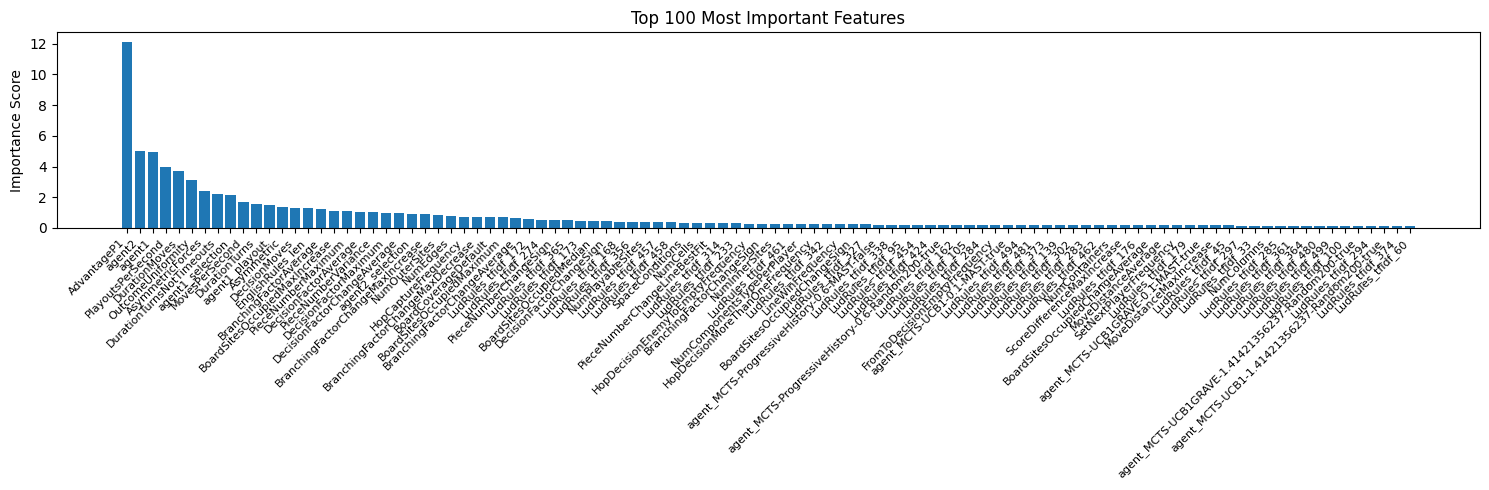

Fold 4 - RMSE: 0.44528206666978076
Fold 5
len(numerical_cols): 870
len(categorical_cols): 5
0:	learn: 0.6146853	test: 0.5437197	best: 0.5437197 (0)	total: 158ms	remaining: 7m 52s
50:	learn: 0.4015160	test: 0.4550104	best: 0.4550104 (50)	total: 9.15s	remaining: 8m 48s
100:	learn: 0.3685149	test: 0.4350912	best: 0.4350912 (100)	total: 18.8s	remaining: 8m 59s
150:	learn: 0.3482761	test: 0.4265475	best: 0.4265475 (150)	total: 28s	remaining: 8m 49s
200:	learn: 0.3342979	test: 0.4224989	best: 0.4224989 (200)	total: 37.6s	remaining: 8m 43s
250:	learn: 0.3232780	test: 0.4196746	best: 0.4196746 (250)	total: 46.7s	remaining: 8m 31s
300:	learn: 0.3138362	test: 0.4176454	best: 0.4175781 (296)	total: 55.9s	remaining: 8m 21s
350:	learn: 0.3062172	test: 0.4154374	best: 0.4154374 (350)	total: 1m 5s	remaining: 8m 11s
400:	learn: 0.2992452	test: 0.4144779	best: 0.4144680 (397)	total: 1m 14s	remaining: 8m 1s
450:	learn: 0.2931587	test: 0.4135055	best: 0.4134769 (447)	total: 1m 23s	remaining: 7m 51s
500:	

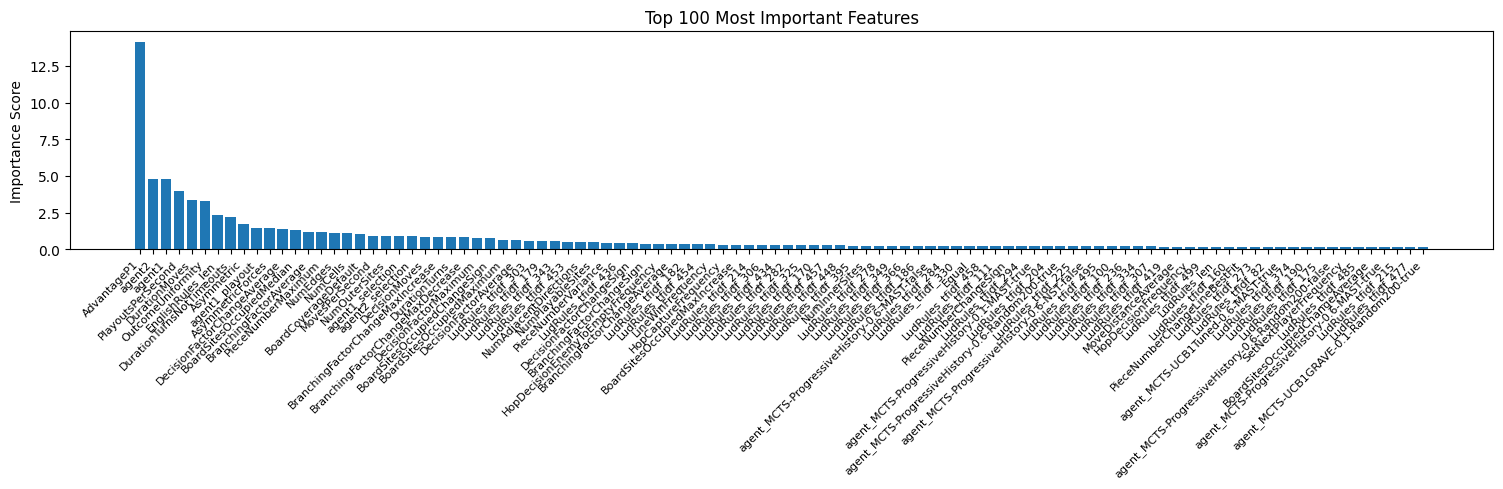

Fold 5 - RMSE: 0.4072145474587911
List of oof scores: [0.42198822339850556, 0.447839035797936, 0.4386859771362182, 0.44528206666978076, 0.4072145474587911]
Average oof score: 0.4322019700922463


In [9]:
# call the function
trained_models1, oof1, oof_scores1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# # save oof predictions
# oof1.to_csv(path_results / 'oof_catboost_cv1.csv', index=False)

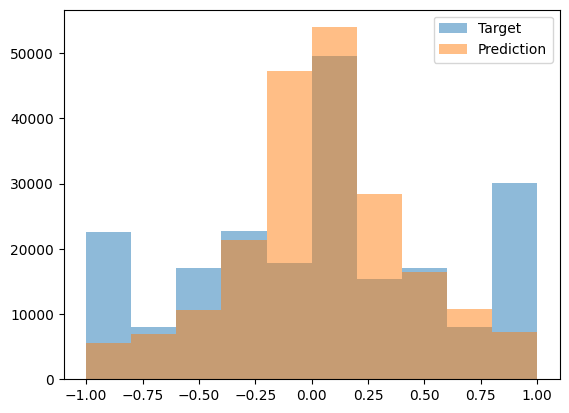

In [10]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [22]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [23]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [ ]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

In [ ]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [26]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder, 
    'scaler': scaler
}

with open('./catboost_predict.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***
